In [1]:
import torch 
from utils import * 
from Kalman2 import *
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

In [2]:
d = 3
m = 8
SNR = 10
array = ArrayModel(m)

T = 40.0
Ts = 1.0
Ns = 200
time = torch.arange(0, T, Ts/Ns)

v1 = 1500
x1 = -27000 + time * v1
y1 = torch.Tensor([27000])
theta1 = torch.atan2(x1, y1) 

v2 = 0
x2 = 0 + time * v2
y2 = torch.Tensor([20000])
theta2 = torch.atan2(x2, y2) 

v3 = -1500
x3 = 32000 + time * v3
y3 = torch.Tensor([30000])
theta3 = torch.atan2(x3, y3)

# theta1 = torch.sin(2 * torch.pi * time / 30)
# theta2 = torch.sin(2 * torch.pi * time / 30 + torch.pi * 2 / 3)
# theta3 = torch.sin(2 * torch.pi * time / 30 + torch.pi * 4 / 3.5)

thetas = torch.stack((theta1, theta2, theta3), dim=1)
received_signal = generate_signal(thetas=thetas, array=array, SNR=SNR)

# thetas_decimated = thetas[Ns-1::Ns]

In [3]:
P = torch.Tensor([[[1, 1 / Ts, 0],
                   [1 / Ts, 2 / Ts ** 2, 0],
                   [0, 0, 0]]]).repeat(d, 1, 1) * 0.01
Q = torch.Tensor([[[Ts ** 4 / 4, Ts ** 3 / 2, Ts ** 2 / 2],
                   [Ts ** 3 / 2, Ts ** 2, Ts],
                   [Ts ** 2 / 2, Ts, 1]]]).repeat(d, 1, 1) * 0.000001

track = Kalman(array=array, d=d, Ts=Ts, P=P, Q=Q)
theta_0, theta_1, theta_2 = track.initialize(received_signal[:3*Ns])
results = [theta_0, theta_1, theta_2]

for i in range(3, int(T/Ts)):
    chunk = received_signal[Ns*i:Ns*(i+1)]
    est_theta_i = track.estimate(chunk)
    results.append(est_theta_i)

results = torch.stack(results, dim=0)

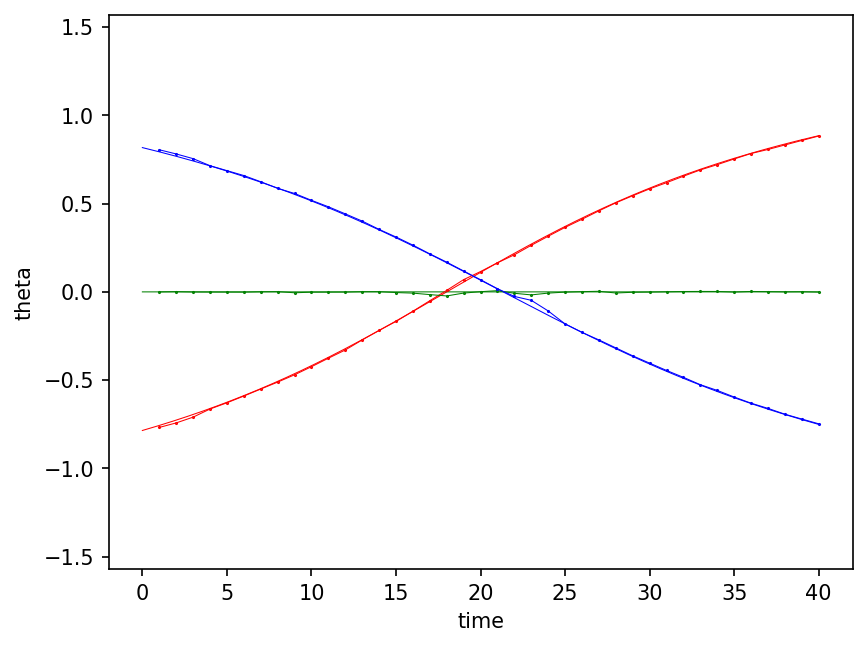

In [4]:
plt.plot(time, thetas[:, 0], color='red', linewidth=0.5)
plt.plot(time, thetas[:, 1], color='green', linewidth=0.5)
plt.plot(time, thetas[:, 2], color='blue', linewidth=0.5)

time_decimated = torch.arange(Ts, T+Ts, Ts)
plt.plot(time_decimated, results[:, 0], color='red', marker='.', linewidth=0.5, markersize=1.0)
plt.plot(time_decimated, results[:, 1], color='green', marker='.', linewidth=0.5, markersize=1.0)
plt.plot(time_decimated, results[:, 2], color='blue', marker='.', linewidth=0.5, markersize=1.0)
plt.xlabel('time')
plt.ylabel('theta')
plt.ylim(-torch.pi/2, torch.pi/2)
plt.show()

In [5]:
# def TrackSubspace(X: torch.Tensor, d: int, Ns: int, array: ArrayModel):

#     subspaces = []
#     cov = X[:Ns].T @ X[:Ns].conj() / Ns
#     theta, _, _ = ESPRIT(cov, d, array)
#     A = array.get_steering_vector(theta)
#     pastd = PAST(d=torch.diag(A.T.conj() @ cov @ A), W=A)
#     subspaces.append(A)
#     for i in range(1, int(X.shape[0]/Ns)):
#         subspaces.append(pastd.update(X[i*Ns:(i+1)*Ns]))
#     return subspaces

# def Sampling(thetas: torch.Tensor, Ns: int, array: ArrayModel):

#     subspaces = []
#     for i in range(1, int(thetas.shape[0]/Ns)):
#         subspaces.append(array.get_steering_vector(thetas[i*Ns]))
#     return subspaces